In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
import os
import shutil

content_path = '/content'

for item in os.listdir(content_path):
    item_path = os.path.join(content_path, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.remove(item_path)
            print(f"File {item_path} dihapus")
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)
            print(f"Folder {item_path} dihapus")
    except Exception as e:
        print(f"Gagal menghapus {item_path}. Reason: {e}")

Folder /content/.config dihapus
Folder /content/sample_data dihapus


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Dependencies

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Dropout,
    InputLayer,
    Flatten
)
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50

# Scikit-learn
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_curve
)
import joblib
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

# Visualization
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Constants

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 224
CHANNELS = 3
SEED = 42
PATH = '/content/dataset-binary'

# Importing Stratified Split Dataset from GDrive

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

SPLIT_DIR = "/content/drive/MyDrive/ResearchMethod/split_dataset_binary"

train_ds = image_dataset_from_directory(
    os.path.join(SPLIT_DIR, 'train'),
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=SEED
)

val_ds = image_dataset_from_directory(
    os.path.join(SPLIT_DIR, 'val'),
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False
)

test_ds = image_dataset_from_directory(
    os.path.join(SPLIT_DIR, 'test'),
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False
)

Found 3700 files belonging to 2 classes.
Found 463 files belonging to 2 classes.
Found 463 files belonging to 2 classes.


In [ ]:
import numpy as np

def count_labels_in_dataset(dataset, class_names):
    class_counts = dict.fromkeys(class_names, 0)
    for _, labels in dataset:
        labels = labels.numpy()
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

# Class names otomatis dari dataset
class_names = train_ds.class_names  # ['normal', 'pneumonia']

# Hitung jumlah per kelas
print("Distribusi kelas di Train:")
print(count_labels_in_dataset(train_ds, class_names))

print("Distribusi kelas di Val:")
print(count_labels_in_dataset(val_ds, class_names))

print("Distribusi kelas di Test:")
print(count_labels_in_dataset(test_ds, class_names))

Distribusi kelas di Train:
{'normal': 1850, 'pneumonia': 1850}
Distribusi kelas di Val:
{'normal': 231, 'pneumonia': 232}
Distribusi kelas di Test:
{'normal': 232, 'pneumonia': 231}


In [ ]:
class_names = train_ds.class_names
n_classes = len(class_names)

print("Class names:", class_names)
print("Jumlah kelas:", n_classes)

Class names: ['normal', 'pneumonia']
Jumlah kelas: 2


# Visualizing the first batch of images

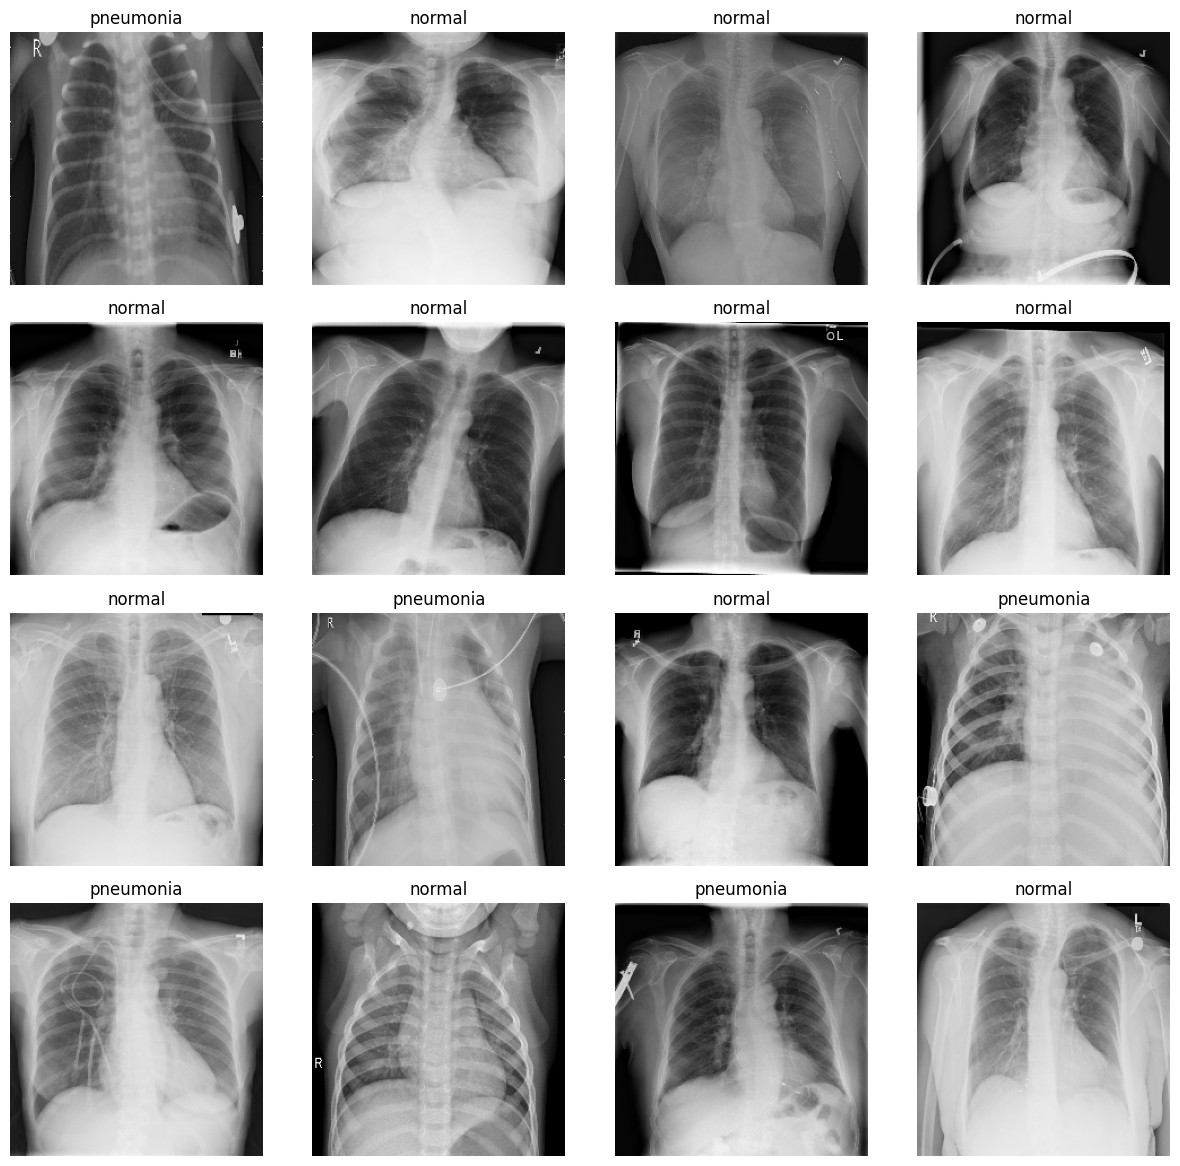

In [ ]:
plt.figure(figsize=(12, 12))
for batch_images, batch_labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(batch_images[i].numpy().astype("uint8"))
        plt.title(class_names[batch_labels[i]])
        plt.tight_layout()
        plt.axis("off")


# Preprocessing + Augmentation

In [ ]:
# Preprocessing Layer (resizing + rescaling)
preprocess_layer = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [ ]:
# Augmentation Layer

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.GaussianNoise(0.1),
])

In [ ]:
# Apply preprocessing + augmentation to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(preprocess_layer(x), training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Apply preprocessing only to val/test sets
val_ds = val_ds.map(lambda x, y: (preprocess_layer(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (preprocess_layer(x), y),
                      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Prefetch
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Feature Extraction


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Reshape, GRU, BatchNormalization, Dense
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [ ]:
base_model = tf.keras.applications.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    pooling='avg'  # Ambil output vektor (global average pooling)
)
base_model.trainable = False

# Fungsi untuk ekstrak fitur dan label dari tf.data.Dataset
def extract_features_and_labels(dataset, model):
    features = []
    labels = []
    for images, lbls in dataset:
        feats = model.predict(images)
        features.append(feats)
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

In [ ]:
import os
import numpy as np

# Path folder penyimpanan
folder_path = '/content/drive/MyDrive/ResearchMethod/ExtractedFeatures-DenseNet201-Binary-AugmentationBerat'
os.makedirs(folder_path, exist_ok=True)

# Path masing-masing file
paths = {
    'X_train': os.path.join(folder_path, 'X_train.npy'),
    'y_train': os.path.join(folder_path, 'y_train.npy'),
    'X_val': os.path.join(folder_path, 'X_val.npy'),
    'y_val': os.path.join(folder_path, 'y_val.npy'),
    'X_test': os.path.join(folder_path, 'X_test.npy'),
    'y_test': os.path.join(folder_path, 'y_test.npy')
}

# Cek apakah semua file sudah ada
if all(os.path.exists(path) for path in paths.values()):
    print("Semua file extraction sudah ada, load dari file.")
    X_train = np.load(paths['X_train'])
    y_train = np.load(paths['y_train'])
    X_val = np.load(paths['X_val'])
    y_val = np.load(paths['y_val'])
    X_test = np.load(paths['X_test'])
    y_test = np.load(paths['y_test'])
else:
    print("File tidak ditemukan, lakukan ekstraksi fitur...")

    # Ekstrak fitur dari dataset
    X_train, y_train = extract_features_and_labels(train_ds, base_model)
    X_val, y_val = extract_features_and_labels(val_ds, base_model)
    X_test, y_test = extract_features_and_labels(test_ds, base_model)

    # Simpan ke file
    np.save(paths['X_train'], X_train)
    np.save(paths['y_train'], y_train)
    np.save(paths['X_val'], X_val)
    np.save(paths['y_val'], y_val)
    np.save(paths['X_test'], X_test)
    np.save(paths['y_test'], y_test)

    print("Ekstraksi dan penyimpanan selesai.")

Semua file extraction sudah ada, load dari file.


# Modelling + Evaluation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
import joblib
import json

In [ ]:
# Lakukan scaling fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Gabungin training & validation untuk evaluasi final
X_train_val_scaled = np.concatenate([X_train_scaled, X_val_scaled])
y_train_val = np.concatenate([y_train, y_val])

In [ ]:
print(np.unique(y_train))
print(np.unique(y_test))

[0 1]
[0 1]


In [ ]:
model_results = []

## Boost Forest

In [ ]:
!ls -la '/content/drive/MyDrive/ResearchMethod/BoostForestPure'

total 42
-rw------- 1 root root  8787 May 18 08:56 BF.py
-rw------- 1 root root 28021 May 15 08:16 BT.py
-rw------- 1 root root   268 May 15 08:16 __init__.py
drwx------ 2 root root  4096 May 15 08:17 __pycache__
-rw------- 1 root root    20 May 15 08:16 _version.py


In [ ]:
# Import BoostForest
import sys
sys.path.append('/content/drive/MyDrive/ResearchMethod/BoostForestPure')

try:
    from BT import BoostTreeClassifier, BoostTreeRegressor
    from BF import BoostForestClassifier, BoostForestRegressor
    print("Import berhasil dari file langsung")
except ImportError as e:
    print(f"Gagal mengimpor: {e}")
    !ls -la '/content/drive/MyDrive/ResearchMethod/BoostForestPure''  # Cek isi folder

Import berhasil dari file langsung


In [ ]:
params = {
    'max_leafs': None,
    'min_sample_leaf_list': 15,
    'reg_alpha_list': 0.01,
    'n_estimators': 50,
    'random_state': 42,
    'max_depth': None,
}

In [ ]:
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Training model
start_train = time.time()
bf_model = BoostForestClassifier(**params)
bf_model.fit(X_train_val_scaled, y_train_val)
training_time = time.time() - start_train

# Inference & Evaluation
start_infer = time.time()
bf_preds = bf_model.predict(X_test_scaled)
inference_time = time.time() - start_infer

# ROC-AUC (dari probabilitas)
if hasattr(bf_model, "predict_proba"):
    bf_proba = bf_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, bf_proba)
    auc = roc_auc_score(y_test, bf_proba)
else:
    fpr, tpr, auc = None, None, None

# Metrics
report_bf = classification_report(y_test, bf_preds, output_dict=True)
accuracy = report_bf['accuracy']
precision = report_bf['weighted avg']['precision']
recall = report_bf['weighted avg']['recall']
f1 = report_bf['weighted avg']['f1-score']

# Simpan ke list
results_bf = {
    "model": "BoostForest",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "auc": auc,
    "training_time": training_time,
    "inference_time": inference_time,
    "fpr": fpr,
    "tpr": tpr
}
model_results.append(results_bf)

In [ ]:
# Simpan model ke file
joblib.dump(bf_model, "/content/drive/MyDrive/ResearchMethod/TrainedModelFix/boostforest_model_tuned.pkl")

# Classification Report
bf_report = classification_report(y_test, bf_preds, digits=4)
print(bf_report)

# Confusion Matrix
cm_bf = confusion_matrix(y_test, bf_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bf, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - BoostForest')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Cek apakah model punya predict_proba
if hasattr(bf_model, "predict_proba"):
    # Probabilitas untuk kelas 1
    bf_proba = bf_model.predict_proba(X_test_scaled)[:, 1]

    # Hitung ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, bf_proba)
    auc_score = roc_auc_score(y_test, bf_proba)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'BoostForest (AUC = {auc_score:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve - Normal vs Pneumonia')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Model tidak mendukung predict_proba(), tidak bisa plot ROC AUC Curve.")

Classification Report:
              precision    recall  f1-score   support

           0     0.9250    0.9569    0.9407       232
           1     0.9552    0.9221    0.9383       231

    accuracy                         0.9395       463
   macro avg     0.9401    0.9395    0.9395       463
weighted avg     0.9400    0.9395    0.9395       463



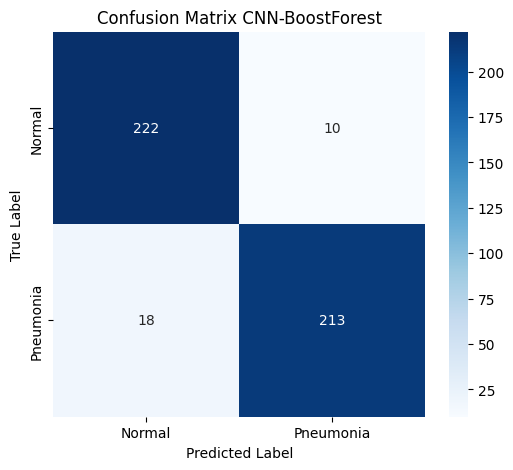

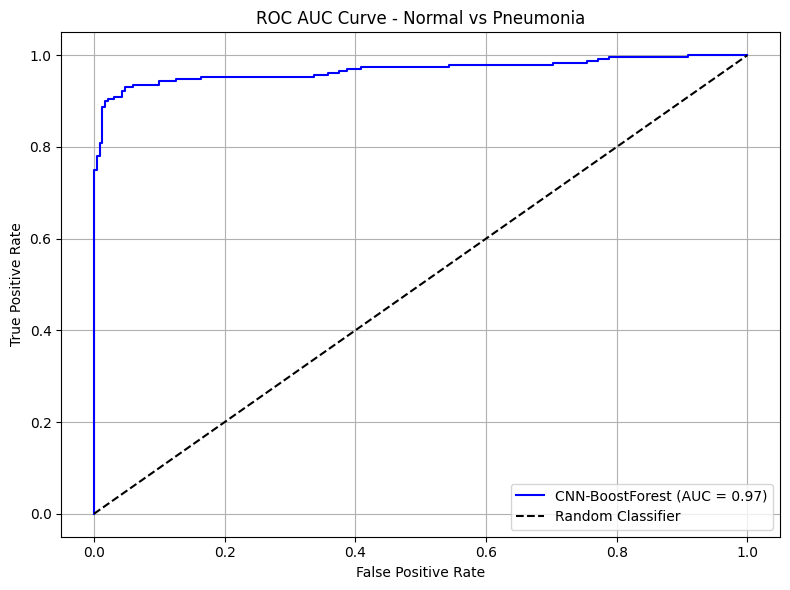

In [ ]:
# Load model dari file
bf_model = joblib.load("/content/drive/MyDrive/ResearchMethod/TrainedModelFix/boostforest_model_tuned.pkl")

# Prediksi
bf_preds = bf_model.predict(X_test_scaled)

# Hitung metrik utama
accuracy = accuracy_score(y_test, bf_preds)
precision = precision_score(y_test, bf_preds, average='micro')
recall = recall_score(y_test, bf_preds, average='micro')
f1 = f1_score(y_test, bf_preds, average='micro')

# Classification Report
bf_report = classification_report(y_test, bf_preds, digits=4)
print("Classification Report:")
print(bf_report)

# Confusion Matrix
cm_bf = confusion_matrix(y_test, bf_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix CNN-BoostForest')
plt.show()

# Space
print(" ")
print(" ")

# ROC AUC Curve
if hasattr(bf_model, "predict_proba"):
    bf_proba = bf_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, bf_proba)
    auc_score = roc_auc_score(y_test, bf_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'CNN-BoostForest (AUC = {auc_score:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve - Normal vs Pneumonia')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Simpan hasil metrik + ROC ke list
    results_bf = {
        "model": "BoostForest",
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc_score,
        "fpr": fpr,
        "tpr": tpr
    }
else:
    print("Model tidak mendukung predict_proba(), tidak bisa plot ROC AUC Curve.")

    # Simpan hasil tanpa ROC
    results_bf = {
        "model": "BoostForest",
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": None,
        "fpr": None,
        "tpr": None
    }

# Tambahkan ke list utama
model_results.append(results_bf)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Hyperparameter Tuning using Validation Set
print("Starting Hyperparameter Tuning...")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Initialize model with fixed random_state
rf = RandomForestClassifier(random_state=42)

# Perform grid search with train set and validate on val set
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get best model
best_rf = grid_search.best_estimator_

# Evaluate on validation set
y_val_pred = best_rf.predict(X_val_scaled)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Validation F1 Score: {val_f1:.4f}")

# 2. Final Training with Combined Train+Val and Test Evaluation
print("\nFinal Training with Combined Train+Val Data...")

# Train final model with best parameters on combined data
final_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
final_rf.fit(X_train_val_scaled, y_train_val)

# Evaluate on test set & mulai hitung waktu inferensi
start_inf_time = time.time()
y_test_pred = final_rf.predict(X_test_scaled)
inference_time = time.time() - start_inf_time

# Hitung metrik
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Hitung probabilitas untuk ROC-AUC
if hasattr(final_rf, "predict_proba"):
    rf_proba = final_rf.predict_proba(X_test_scaled)[:, 1]  # asumsi kelas positif = 1
    fpr, tpr, _ = roc_curve(y_test, rf_proba)
    auc = roc_auc_score(y_test, rf_proba)
else:
    rf_proba = None
    fpr, tpr, auc = None, None, None

# Simpan hasil evaluasi ke list
results_rf = {
    "model": "RandomForest",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "auc": auc,
    "training_time": grid_search.refit_time_,  # waktu training dari GridSearchCV
    "inference_time": inference_time,
    "fpr": fpr,
    "tpr": tpr
}
model_results.append(results_rf)

# 1. Simpan model dengan joblib
joblib.dump(final_rf, "/content/drive/MyDrive/ResearchMethod/TrainedModelFix/random_forest_model.pkl")

# 2. Simpan best parameters ke file JSON
with open("/content/drive/MyDrive/ResearchMethod/TunedParameter/random_forest_best_params.json", "w") as f:
    json.dump(grid_search.best_params_, f, indent=4)

print("\nModel dan parameter berhasil disimpan dengan joblib dan JSON.")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0     0.9391    0.9310    0.9351       232
           1     0.9313    0.9394    0.9353       231

    accuracy                         0.9352       463
   macro avg     0.9352    0.9352    0.9352       463
weighted avg     0.9352    0.9352    0.9352       463



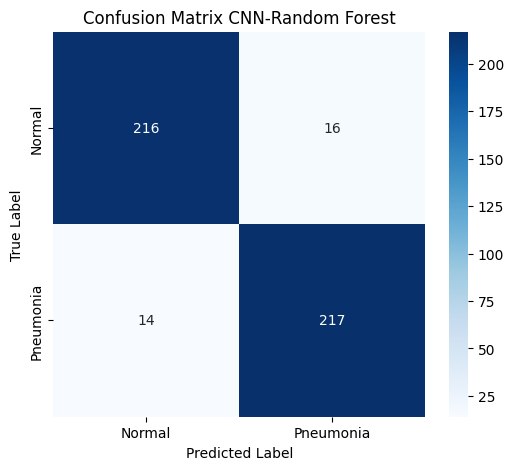

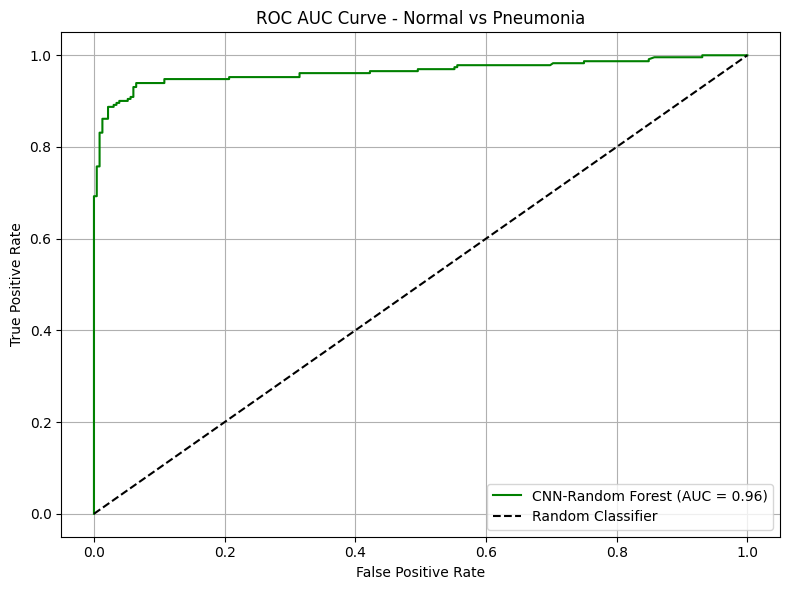

In [ ]:
# Load model dari file
rf_model = joblib.load("/content/drive/MyDrive/ResearchMethod/TrainedModelFix/random_forest_model.pkl")

# Prediksi
rf_preds = rf_model.predict(X_test_scaled)

# Hitung metrik utama
accuracy = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='micro')
recall = recall_score(y_test, rf_preds, average='micro')
f1 = f1_score(y_test, rf_preds, average='micro')

# Classification Report
rf_report = classification_report(y_test, rf_preds, digits=4)
print("Classification Report:")
print(rf_report)

# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix CNN-Random Forest')
plt.show()

# Space
print("\n" * 2)

# ROC AUC Curve
if hasattr(rf_model, "predict_proba"):
    rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, rf_proba)
    auc_score = roc_auc_score(y_test, rf_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'CNN-Random Forest (AUC = {auc_score:.2f})', color='green')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve - Normal vs Pneumonia')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Simpan hasil metrik + ROC ke list
    results_rf = {
        "model": "Random Forest",
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc_score,
        "fpr": fpr,
        "tpr": tpr
    }
else:
    print("Model tidak mendukung predict_proba(), tidak bisa plot ROC AUC Curve.")

    # Simpan hasil tanpa ROC
    results_rf = {
        "model": "Random Forest",
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": None,
        "fpr": None,
        "tpr": None
    }

# Tambahkan ke list utama
model_results.append(results_rf)

## Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
# Grid Search untuk ExtraTrees
et_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

et = ExtraTreesClassifier(class_weight='balanced', random_state=42)
grid_et = GridSearchCV(et, et_param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)

grid_et.fit(X_train_scaled, y_train)

# Tampilkan hasil tuning
best_et_params = grid_et.best_params_
best_et_score = grid_et.best_score_
print("Best ExtraTrees params:", best_et_params)
print("Best F1 Score ET (CV):", round(best_et_score, 4))

print("\nFinal Training with Combined Train+Val Data...")

# Final training dengan (train + val)
start_time = time.time()
final_et = ExtraTreesClassifier(**best_et_params, class_weight='balanced', random_state=42)
final_et.fit(X_train_val_scaled, y_train_val)
training_time = time.time() - start_time

# Prediksi di test set
y_pred_et = final_et.predict(X_test_scaled)

# Classification report
report_et = classification_report(y_test, y_pred_et, digits=4)
print("\nClassification Report - ExtraTrees:\n", report_et)

# Confusion matrix
cm_et = confusion_matrix(y_test, y_pred_et)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_et, display_labels=final_et.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - ExtraTrees")
plt.grid(False)
plt.show()

# ROC-AUC
if hasattr(final_et, "predict_proba"):
    et_proba = final_et.predict_proba(X_test_scaled)[:, 1]
    fpr_et, tpr_et, _ = roc_curve(y_test, et_proba)
    auc_et = roc_auc_score(y_test, et_proba)
    print("AUC Score - ExtraTrees:", round(auc_et, 4))
else:
    fpr_et, tpr_et, auc_et = None, None, None

# Hitung metrik
accuracy_et = accuracy_score(y_test, y_pred_et)
precision_et = precision_score(y_test, y_pred_et, average='weighted')
recall_et = recall_score(y_test, y_pred_et, average='weighted')
f1_et = f1_score(y_test, y_pred_et, average='weighted')

# Simpan ke dictionary
results_et = {
    "model": "ExtraTrees",
    "accuracy": accuracy_et,
    "precision": precision_et,
    "recall": recall_et,
    "f1": f1_et,
    "auc": auc_et,
    "training_time": training_time,
    "inference_time": inference_time,
    "fpr": fpr_et,
    "tpr": tpr_et
}

# Simpan ke list
model_results.append(results_et)

# Simpan model
joblib.dump(final_et, "/content/drive/MyDrive/ResearchMethod/TrainedModelFix/extratrees_model.pkl")

# Simpan best parameter
with open("/content/drive/MyDrive/ResearchMethod/TunedParameter/extratrees_best_params.json", "w") as f:
    json.dump(best_et_params, f, indent=4)

print("\nModel ExtraTrees & best params berhasil disimpan.")

Classification Report:
              precision    recall  f1-score   support

           0     0.9397    0.9397    0.9397       232
           1     0.9394    0.9394    0.9394       231

    accuracy                         0.9395       463
   macro avg     0.9395    0.9395    0.9395       463
weighted avg     0.9395    0.9395    0.9395       463



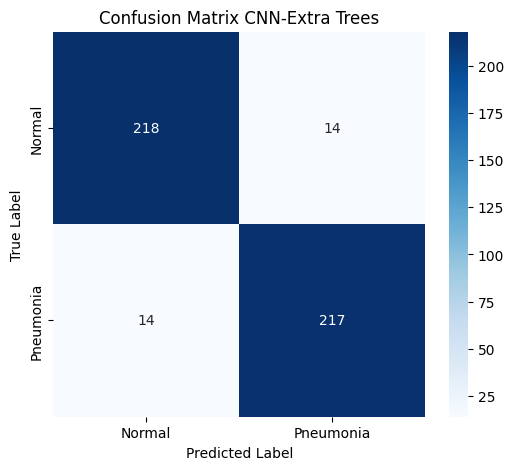

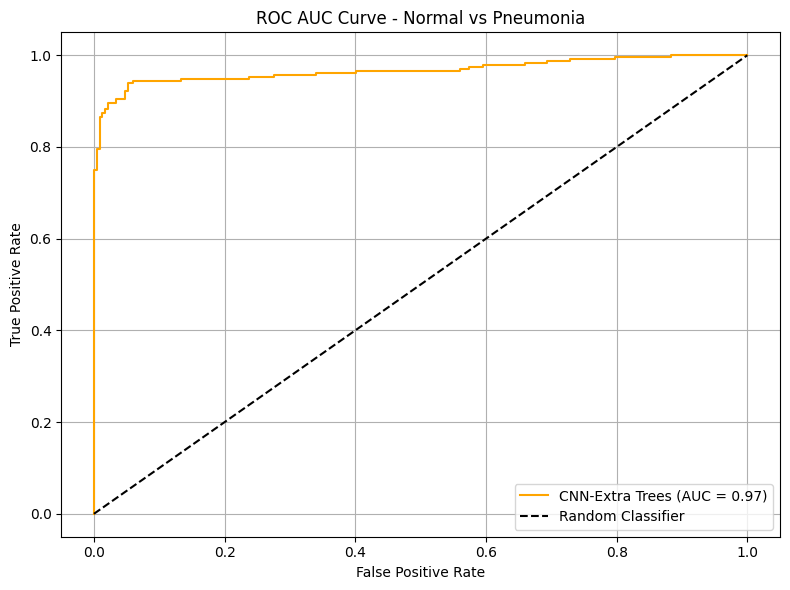

In [ ]:
# Load model dari file
et_model = joblib.load("/content/drive/MyDrive/ResearchMethod/TrainedModelFix/extratrees_model.pkl")

# Prediksi
et_preds = et_model.predict(X_test_scaled)

# Hitung metrik utama
accuracy = accuracy_score(y_test, et_preds)
precision = precision_score(y_test, et_preds, average='micro')
recall = recall_score(y_test, et_preds, average='micro')
f1 = f1_score(y_test, et_preds, average='micro')

# Classification Report
et_report = classification_report(y_test, et_preds, digits=4)
print("Classification Report:")
print(et_report)

# Confusion Matrix
cm_et = confusion_matrix(y_test, et_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_et, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix CNN-Extra Trees')
plt.show()

# Space
print("\n" * 2)

# ROC AUC Curve
if hasattr(et_model, "predict_proba"):
    et_proba = et_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, et_proba)
    auc_score = roc_auc_score(y_test, et_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'CNN-Extra Trees (AUC = {auc_score:.2f})', color='orange')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve - Normal vs Pneumonia')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Simpan hasil metrik + ROC ke list
    results_et = {
        "model": "Extra Trees",
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc_score,
        "fpr": fpr,
        "tpr": tpr
    }
else:
    print(" Model tidak mendukung predict_proba(), tidak bisa plot ROC AUC Curve.")

    # Simpan hasil tanpa ROC
    results_et = {
        "model": "Extra Trees",
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": None,
        "fpr": None,
        "tpr": None
    }

# Tambahkan ke list utama
model_results.append(results_et)

## XGBoost

In [ ]:
pip install xgboost

In [ ]:
import xgboost as xgb

In [ ]:
# Import jika belum
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve,
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score
)

# Load model dari file
xgb_model = joblib.load("/content/drive/MyDrive/ResearchMethod/TrainedModelFix/xgboost_model.pkl")

# Prediksi
xgb_preds = xgb_model.predict(X_test_scaled)

# Hitung metrik utama
accuracy = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds)
recall = recall_score(y_test, xgb_preds)
f1 = f1_score(y_test, xgb_preds)

# Classification Report
xgb_report = classification_report(y_test, xgb_preds, digits=4)
print("📄 Classification Report:")
print(xgb_report)

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True


📄 Classification Report:
              precision    recall  f1-score   support

           0     0.9237    0.9397    0.9316       232
           1     0.9383    0.9221    0.9301       231

    accuracy                         0.9309       463
   macro avg     0.9310    0.9309    0.9309       463
weighted avg     0.9310    0.9309    0.9309       463



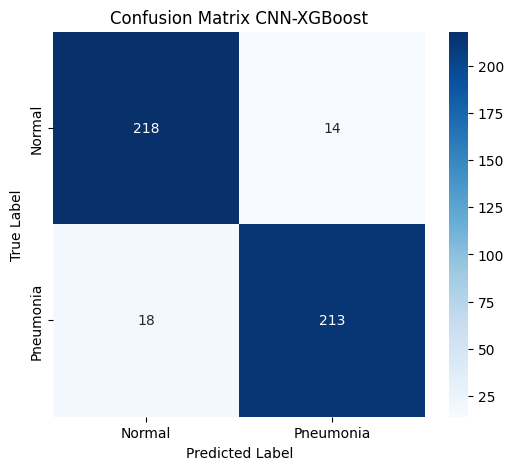

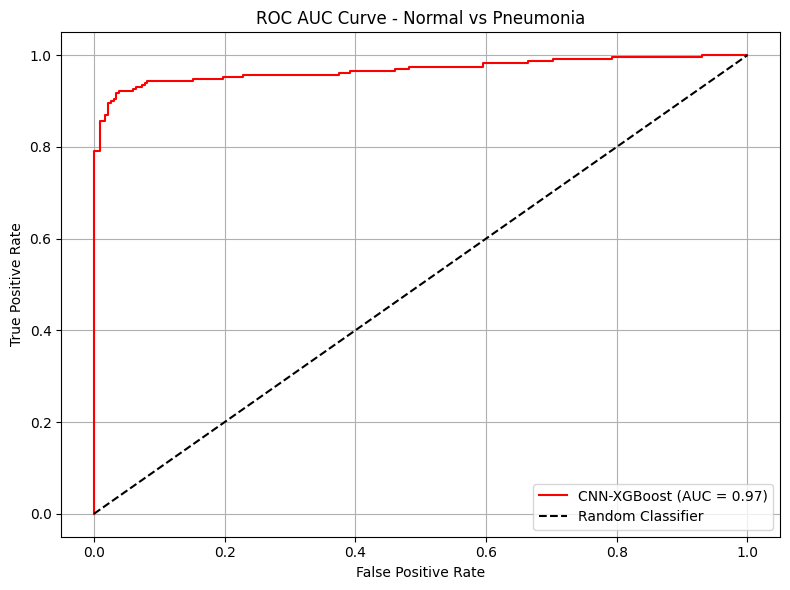

In [ ]:
# Load model dari file
xgb_model = joblib.load("/content/drive/MyDrive/ResearchMethod/TrainedModelFix/xgboost_model.pkl")

# Prediksi
xgb_preds = xgb_model.predict(X_test_scaled)

# Hitung metrik utama
accuracy = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds, average='micro')
recall = recall_score(y_test, xgb_preds, average='micro')
f1 = f1_score(y_test, xgb_preds, average='micro')

# Classification Report
xgb_report = classification_report(y_test, xgb_preds, digits=4)
print("📄 Classification Report:")
print(xgb_report)

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix CNN-XGBoost')
plt.show()

# Space
print("\n" * 2)

# ROC AUC Curve
if hasattr(xgb_model, "predict_proba"):
    xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, xgb_proba)
    auc_score = roc_auc_score(y_test, xgb_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'CNN-XGBoost (AUC = {auc_score:.2f})', color='red')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve - Normal vs Pneumonia')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Simpan hasil metrik + ROC ke list
    results_xgb = {
        "model": "XGBoost",
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc_score,
        "fpr": fpr,
        "tpr": tpr
    }
else:
    print("Model tidak mendukung predict_proba(), tidak bisa plot ROC AUC Curve.")

    # Simpan hasil tanpa ROC
    results_xgb = {
        "model": "XGBoost",
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": None,
        "fpr": None,
        "tpr": None
    }

# Tambahkan ke list utama
model_results.append(results_xgb)


## Light GBM

In [ ]:
pip install lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
# Grid Search (Hyperparameter Tuning)
lgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
}

lgb_model = lgb.LGBMClassifier(objective='binary', random_state=42)

grid_lgb = GridSearchCV(
    lgb_model, lgb_param_grid, cv=3,
    scoring='f1_weighted', n_jobs=-1, verbose=1
)
grid_lgb.fit(X_train_scaled, y_train)

best_lgb_params = grid_lgb.best_params_
print("Best LightGBM params:", best_lgb_params)
print("Best F1 Score LGBM:", grid_lgb.best_score_)

print("\nFinal Training with Combined Train+Val Data...")

# Final Training on Train+Val
start_train = time.time()
final_lgb = lgb.LGBMClassifier(objective='binary', random_state=42, **best_lgb_params)
final_lgb.fit(X_train_val_scaled, y_train_val)
training_time = time.time() - start_train

# Inference on Test Set
start_infer = time.time()
y_pred_lgb = final_lgb.predict(X_test_scaled)
inference_time = time.time() - start_infer

# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred_lgb)
precision = precision_score(y_test, y_pred_lgb, average='weighted')
recall = recall_score(y_test, y_pred_lgb, average='weighted')
f1 = f1_score(y_test, y_pred_lgb, average='weighted')

# ROC-AUC and Curve
if hasattr(final_lgb, "predict_proba"):
    lgb_proba = final_lgb.predict_proba(X_test_scaled)[:, 1]
    fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_proba)
    auc = roc_auc_score(y_test, lgb_proba)
else:
    fpr_lgb, tpr_lgb, auc = None, None, None

# Classification Report & Confusion Matrix
print("\nClassification Report LightGBM (4 decimal):")
print(classification_report(y_test, y_pred_lgb, digits=4))

cm_lgb = confusion_matrix(y_test, y_pred_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=['Normal', 'Pneumonia'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - LightGBM")
plt.grid(False)
plt.show()

# Simpan hasil ke dict model_results
results_lgb = {
    "model": "LightGBM",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "auc": auc,
    "training_time": training_time,
    "inference_time": inference_time,
    "fpr": fpr_lgb,
    "tpr": tpr_lgb
}
model_results.append(results_lgb)

# Simpan model & best params
joblib.dump(final_lgb, "/content/drive/MyDrive/ResearchMethod/TrainedModelFix/lightgbm_model.pkl")
with open("/content/drive/MyDrive/ResearchMethod/TunedParameter/lightgbm_best_params.json", "w") as f:
    json.dump(best_lgb_params, f, indent=4)

print("\nModel dan parameter LightGBM berhasil disimpan.")


Classification Report:
              precision    recall  f1-score   support

           0     0.9316    0.9397    0.9356       232
           1     0.9389    0.9307    0.9348       231

    accuracy                         0.9352       463
   macro avg     0.9352    0.9352    0.9352       463
weighted avg     0.9352    0.9352    0.9352       463



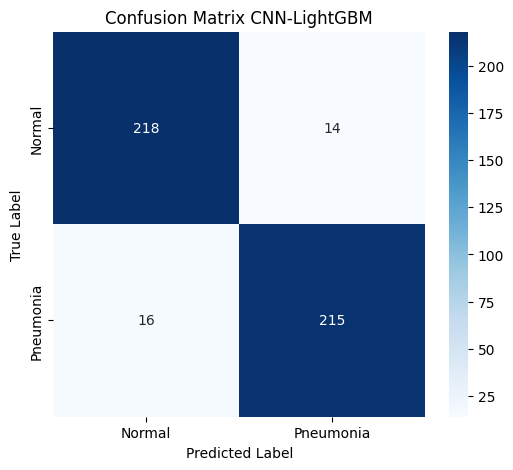

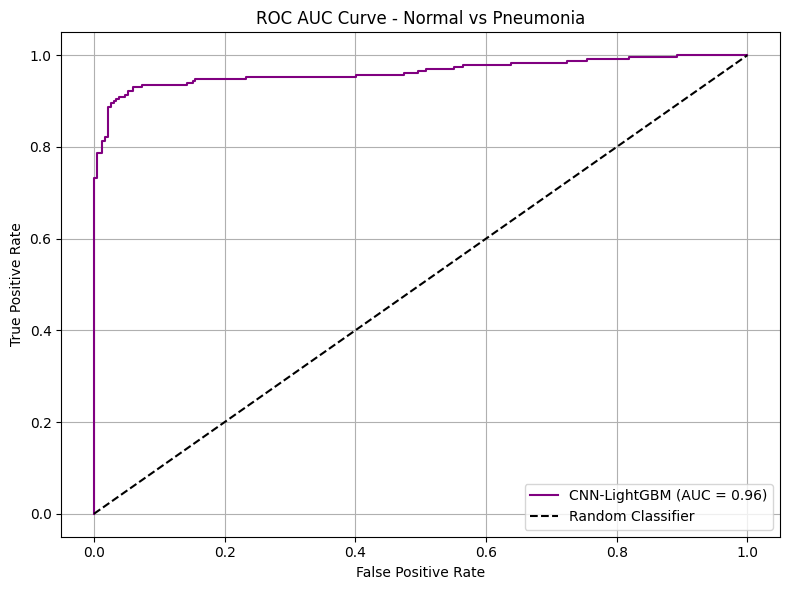

In [ ]:
# Load model dari file
lgb_model = joblib.load("/content/drive/MyDrive/ResearchMethod/TrainedModelFix/lightgbm_model.pkl")

# Prediksi
lgb_preds = lgb_model.predict(X_test_scaled)

# Hitung metrik utama
accuracy = accuracy_score(y_test, lgb_preds)
precision = precision_score(y_test, lgb_preds, average='micro')
recall = recall_score(y_test, lgb_preds, average='micro')
f1 = f1_score(y_test, lgb_preds, average='micro')

# Classification Report
lgb_report = classification_report(y_test, lgb_preds, digits=4)
print("Classification Report:")
print(lgb_report)

# Confusion Matrix
cm_lgb = confusion_matrix(y_test, lgb_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix CNN-LightGBM')
plt.show()

# Space
print("\n" * 2)

# ROC AUC Curve
if hasattr(lgb_model, "predict_proba"):
    lgb_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, lgb_proba)
    auc_score = roc_auc_score(y_test, lgb_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'CNN-LightGBM (AUC = {auc_score:.2f})', color='purple')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve - Normal vs Pneumonia')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Simpan hasil metrik + ROC ke list
    results_lgb = {
        "model": "LightGBM",
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc_score,
        "fpr": fpr,
        "tpr": tpr
    }
else:
    print("Model tidak mendukung predict_proba(), tidak bisa plot ROC AUC Curve.")

    # Simpan hasil tanpa ROC
    results_lgb = {
        "model": "LightGBM",
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": None,
        "fpr": None,
        "tpr": None
    }

# Tambahkan ke list utama
model_results.append(results_lgb)

# Analisis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tabel Evaluasi Kinerja Semua Model
eval_df = pd.DataFrame(model_results)[["model", "accuracy", "precision", "recall", "f1"]]
eval_df.set_index("model", inplace=True)
print("\nTabel Evaluasi Kinerja Model:")
print(eval_df.round(4))


📊 Tabel Evaluasi Kinerja Model:
               accuracy  precision  recall      f1
model                                             
BoostForest      0.9395     0.9395  0.9395  0.9395
Random Forest    0.9352     0.9352  0.9352  0.9352
Extra Trees      0.9395     0.9395  0.9395  0.9395
XGBoost          0.9309     0.9309  0.9309  0.9309
LightGBM         0.9352     0.9352  0.9352  0.9352


Tidak sus, itu wajar. Ini artinya modelmu sangat konsisten dan seimbang dalam performanya pada kedua kelas.

In [ ]:
print("Akurasi range:", eval_df['accuracy'].min(), "-", eval_df['accuracy'].max())
print("F1 Score range:", eval_df['f1'].min(), "-", eval_df['f1'].max())

Akurasi range: 0.9308855291576674 - 0.9395248380129589
F1 Score range: 0.9308855291576674 - 0.9395248380129589


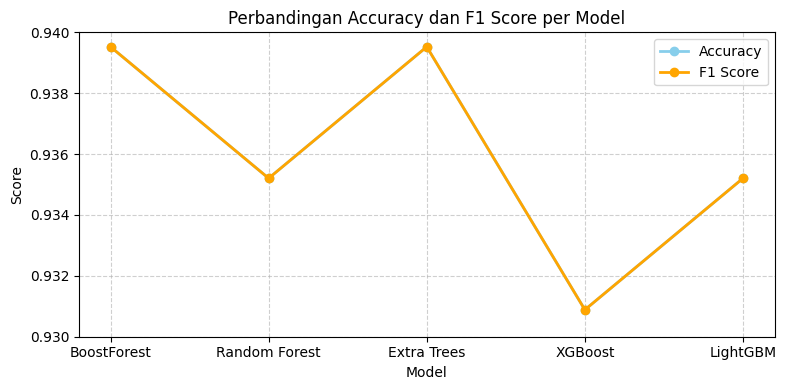

In [ ]:
plt.figure(figsize=(8, 4))

# Accuracy line
plt.plot(eval_df.index, eval_df['accuracy'], marker='o', label='Accuracy', color='skyblue', linewidth=2)

# F1 Score line
plt.plot(eval_df.index, eval_df['f1'], marker='o', label='F1 Score', color='orange', linewidth=2)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Perbandingan Accuracy dan F1 Score per Model')

# Zoom lebih detail sesuai range nilai
plt.ylim(0.930, 0.940)  # bisa disesuaikan jadi misalnya (0.931, 0.939) kalau masih terlalu lebar

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

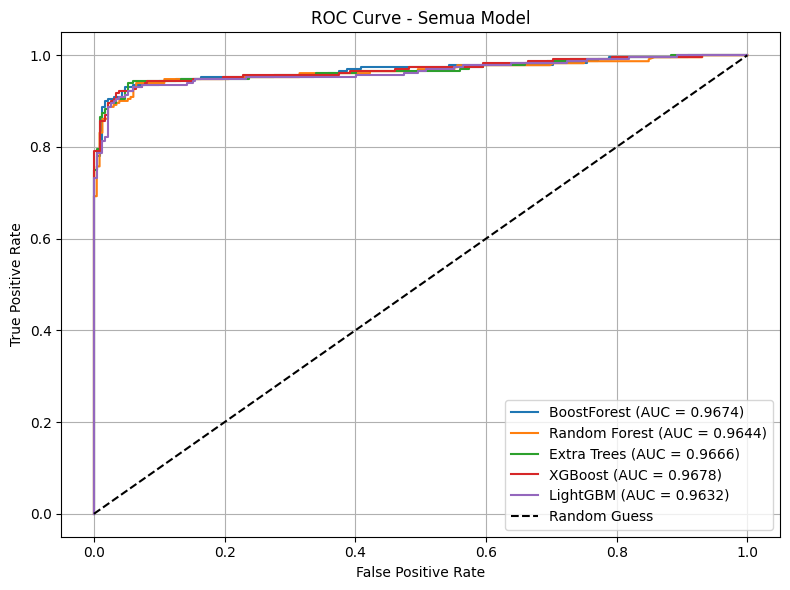

In [ ]:
# 4. ROC Curve Semua Model
plt.figure(figsize=(8, 6))
for res in model_results:
    if res["fpr"] is not None and res["tpr"] is not None:
        plt.plot(res["fpr"], res["tpr"], label=f"{res['model']} (AUC = {res['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Semua Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

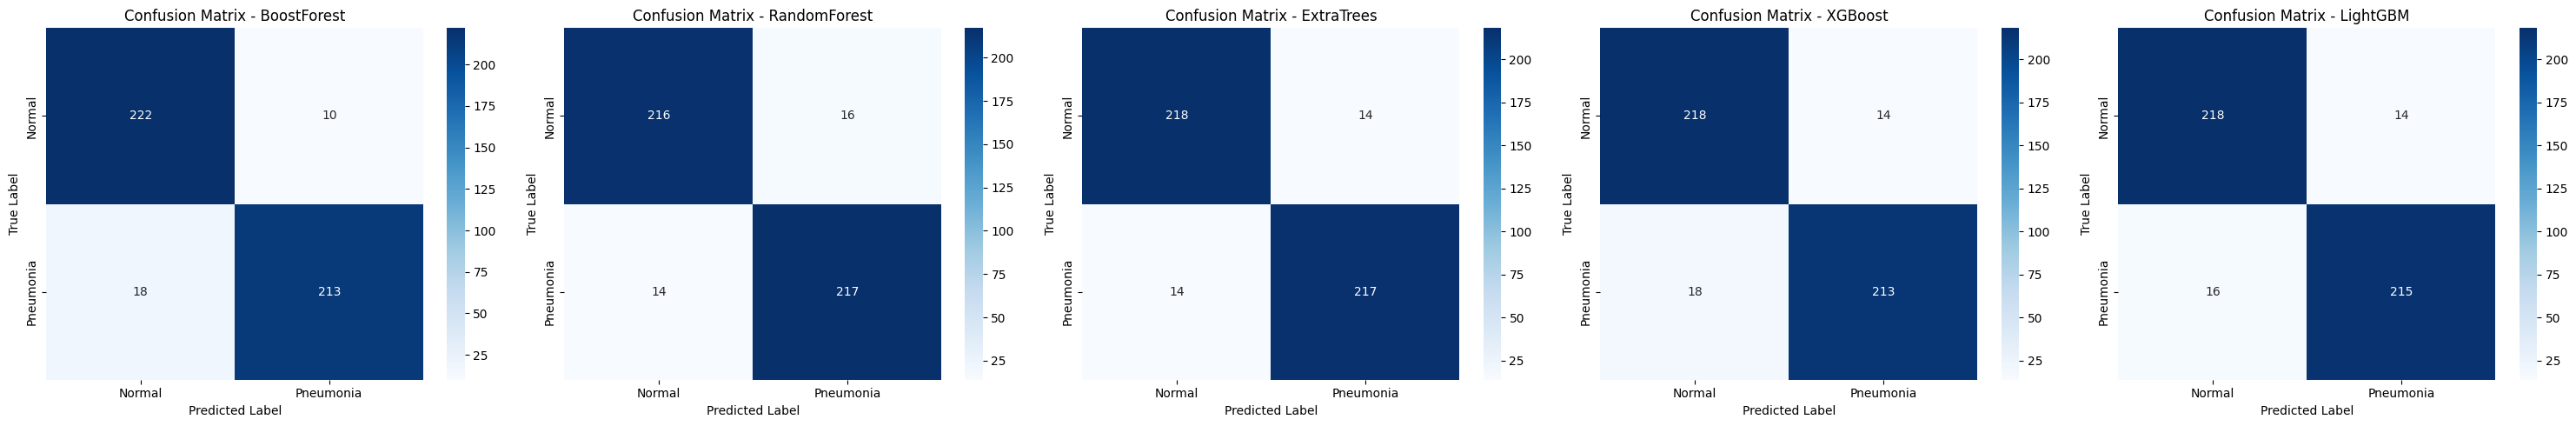

In [ ]:
# Daftar model dan path-nya
model_paths = {
    'BoostForest': '/content/drive/MyDrive/ResearchMethod/TrainedModelFix/boostforest_model_tuned.pkl',
    'RandomForest': '/content/drive/MyDrive/ResearchMethod/TrainedModelFix/random_forest_model.pkl',
    'ExtraTrees': '/content/drive/MyDrive/ResearchMethod/TrainedModelFix/extratrees_model.pkl',
    'XGBoost': '/content/drive/MyDrive/ResearchMethod/TrainedModelFix/xgboost_model.pkl',
    'LightGBM': '/content/drive/MyDrive/ResearchMethod/TrainedModelFix/lightgbm_model.pkl'
}

# Untuk menyimpan hasil prediksi dan modelnya
models = {}
predictions = {}
conf_matrices = {}

# Load semua model dan prediksi
for name, path in model_paths.items():
    models[name] = joblib.load(path)                   # Load model
    predictions[name] = models[name].predict(X_test_scaled)  # Prediksi
    conf_matrices[name] = confusion_matrix(y_test, predictions[name])  # Confusion matrix

# Tampilkan semua confusion matrix secara horizontal
num_models = len(conf_matrices)
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5))  # 6 inch per plot width

# Kalau cuma 1 model, axes bukan array → ubah jadi list
if num_models == 1:
    axes = [axes]

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'],
                ax=ax)
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()